# Drzewa wzmocnione gradientowo

Będę korzystał z dodatkowej biblioteki, która implementuje (chyba) state-of-the-art wersję XGBoosta, więc odbrze ją znać. Natomiast GradientBoostedTrees są też dostępne w sklearnie

In [1]:
# pip install xgboost

[XGboost docs](https://xgboost.readthedocs.io/en/stable/parameter.html)

### Ładowanie bibliotek

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

c:\users\beljasiak\appdata\local\programs\python\python39\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: 0.0.07d6de2784363a81e65d5af245dc41b3e71eb65b5- is an invalid version and will not be supported in a future release
  warnings.warn(


## Ponownie załadujmy titanica
Chciałoby się zacytować tu pewną piosenkę...

In [3]:
titanic = pd.read_csv("../lab3/titanic.csv")

Szybkie przekształcenie danych do postaci uczącej, tym razem bez skalowania zmiennych liczbowych. Dlaczego?

In [4]:
titanic = titanic.drop('Cabin', axis = 1)

titanic.loc[titanic['Age'].isna(),'Age'] = titanic['Age'].mean()
titanic.loc[titanic['Fare'].isna(),'Fare'] = titanic['Fare'].median()
titanic.loc[titanic['Embarked'].isna(),'Embarked'] = titanic['Embarked'].mode().iloc[0]
titanic['name_length'] = titanic['Name'].str.len()

titanic = titanic.drop(["PassengerId","Name","Ticket"], axis=1)
    
titanic['Sex'] = (titanic['Sex'] == 'female')*1

encoded = pd.get_dummies(titanic[["Pclass","Embarked"]].astype(str))
encoded = encoded.drop(["Pclass_1","Embarked_C"], axis = 1)
titanic = titanic.drop(["Pclass","Embarked"], axis=1)
titanic = pd.concat([titanic, encoded], axis = 1)

Podzielmy dane na zbiory uczący i treningowy.

In [5]:
y = titanic['Survived']
X = titanic.drop("Survived", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, train_size=0.7)

### Szybkie przypomninie Random Foresta

In [6]:
rf = RandomForestClassifier()

In [7]:
rf.fit(X_train, y_train).score(X_test, y_test)

0.8447837150127226

In [8]:
rf.estimators_[:5]

[DecisionTreeClassifier(max_features='auto', random_state=1871618727),
 DecisionTreeClassifier(max_features='auto', random_state=1475547305),
 DecisionTreeClassifier(max_features='auto', random_state=1516680769),
 DecisionTreeClassifier(max_features='auto', random_state=2063722346),
 DecisionTreeClassifier(max_features='auto', random_state=1870651392)]

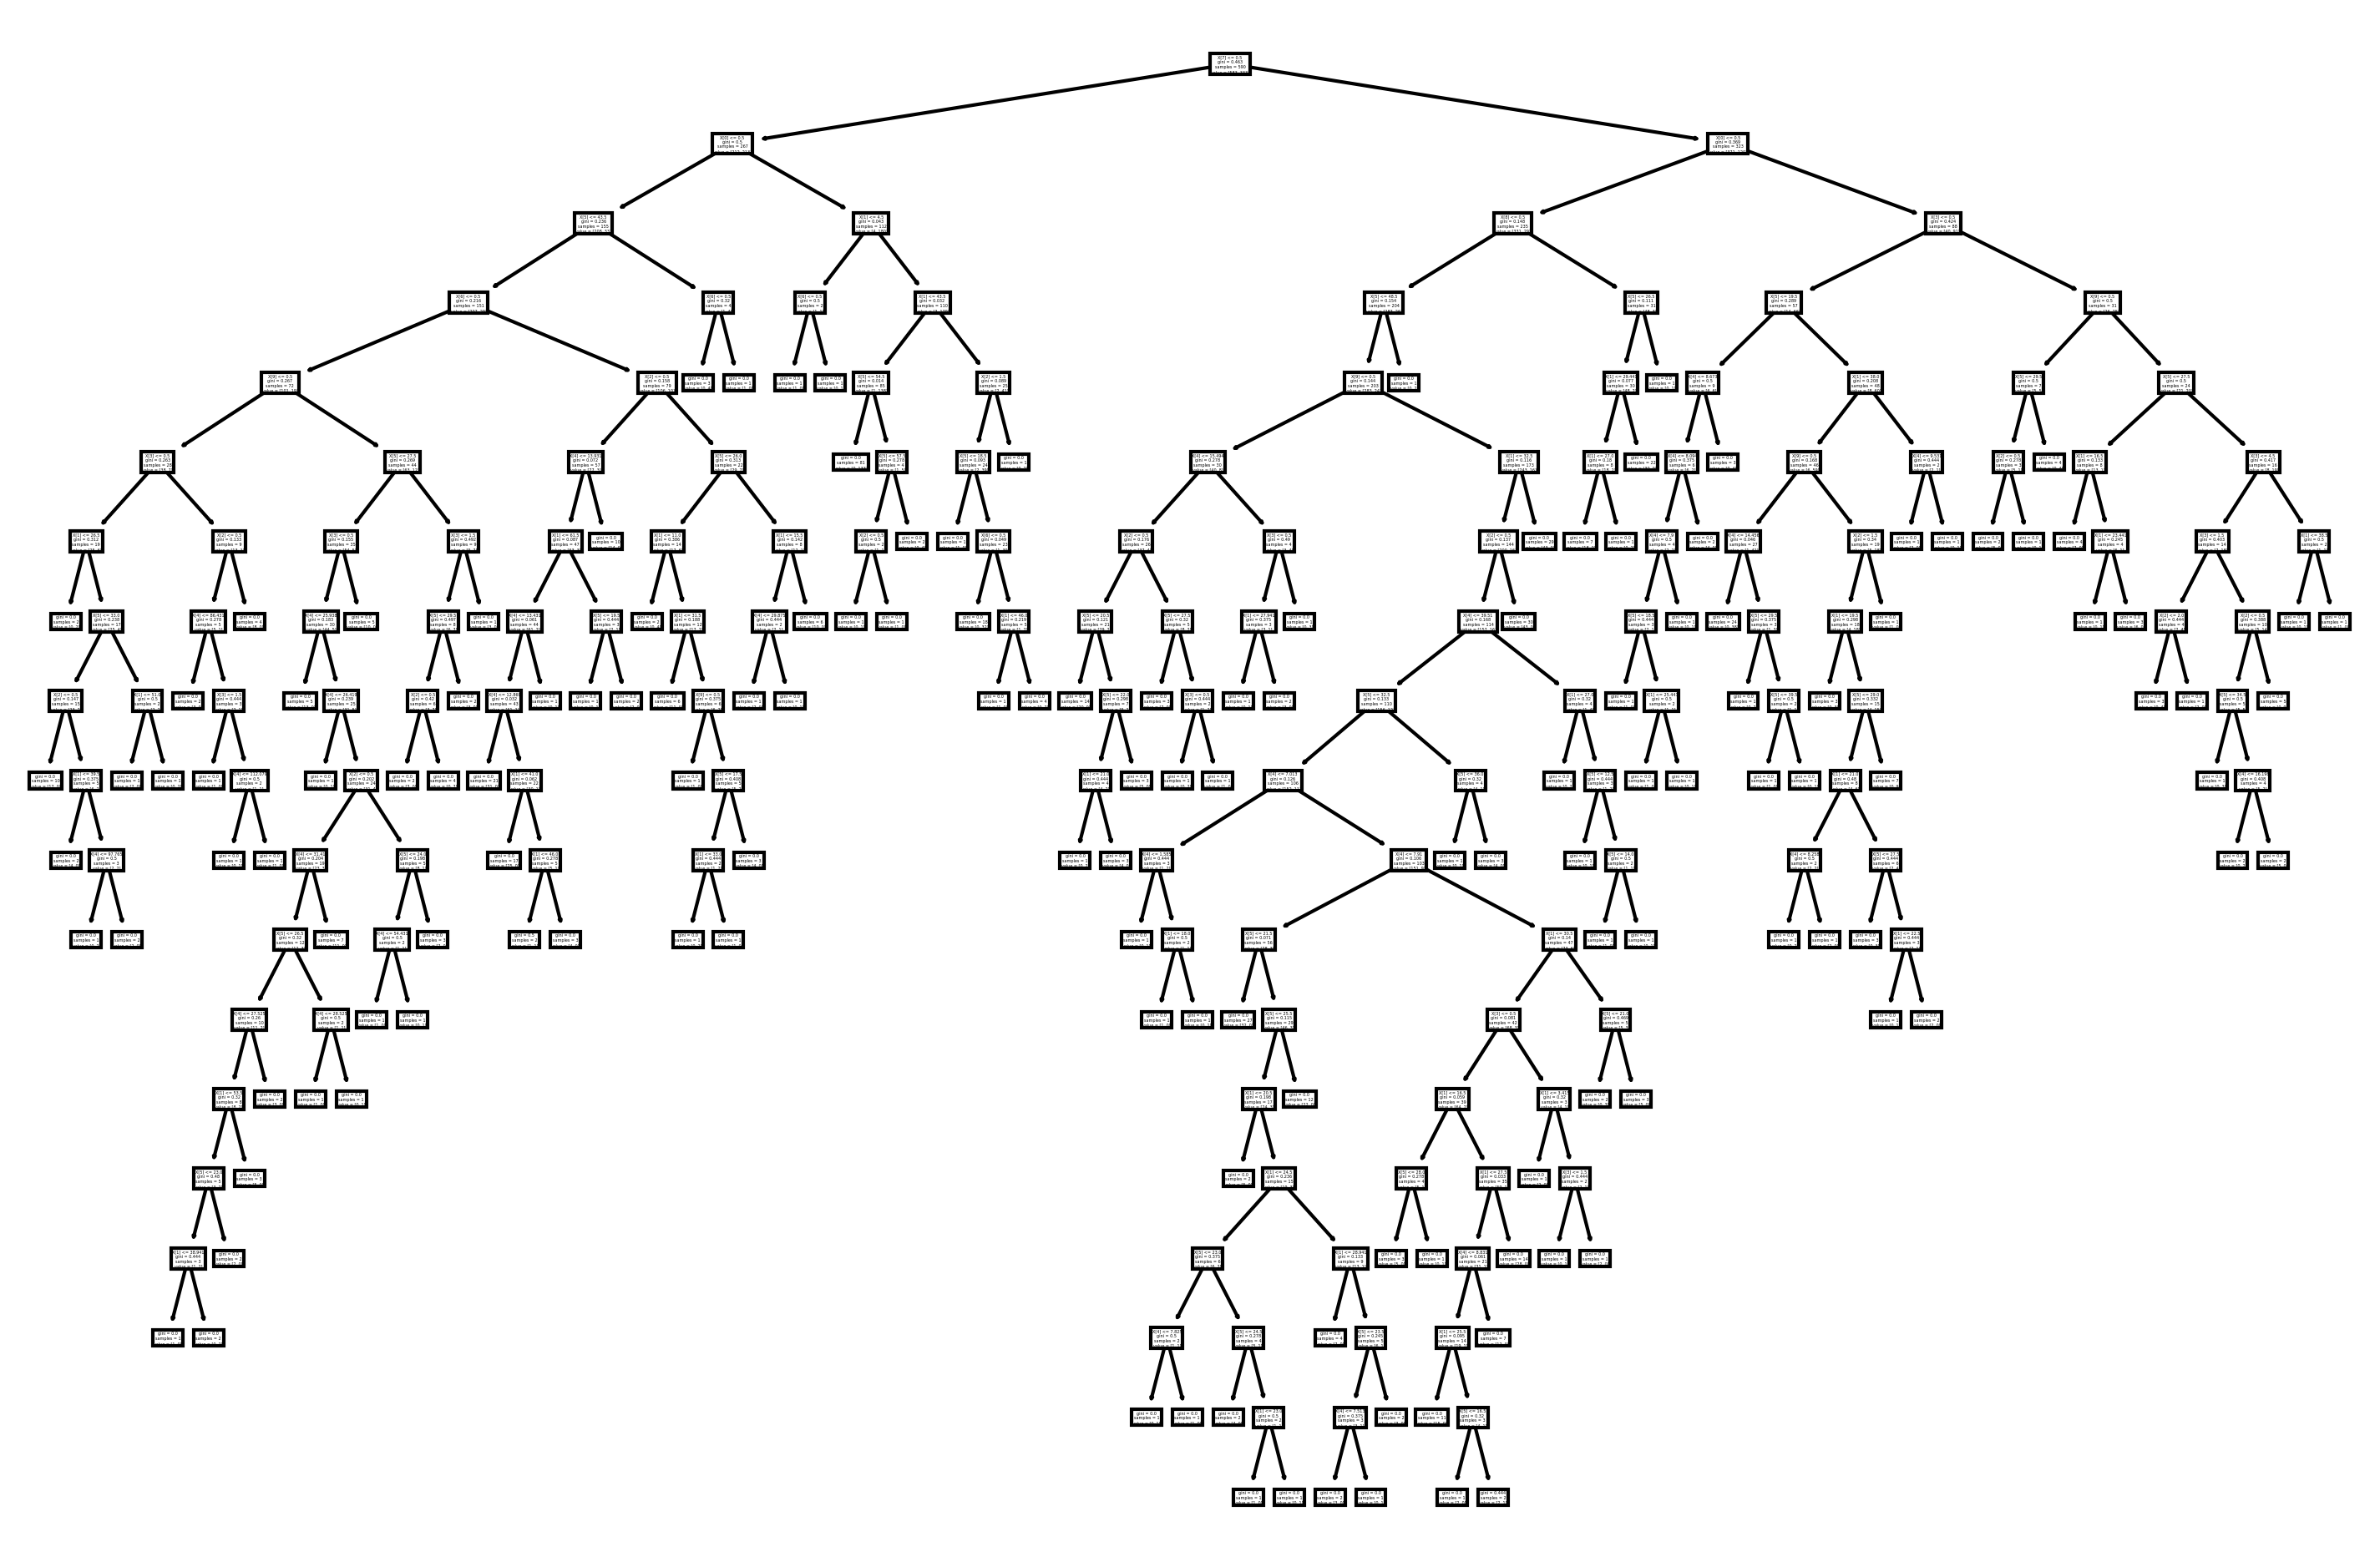

In [9]:
plt.figure(dpi=300)
plot_tree(rf.estimators_[0])
plt.show()

## eXtreme Gradient Boosted Trees

Wieloelementowe narzędzie machine learningowe bazujące na jednym algorytmie, 'boostowanym' drzewie decyzyjnym 

- ### Gradient Boosting
 - *Loss function* dla klasyfikacji i regresji
 - Regularyzacja
 
- ### Drzewa 
 - Jak budowane są drzewa w kolejnych krokach?
 
- ### Czemu eXtreme? 
 - Approximate Greedy Algorithm 
 - Parallel learning
 - Weighted Quantile Sketch
 - Sparse-Aware Split Finding
 - Cache-Aware Access
 - Blocks for Out-of-Core Computation


# Gradient Boosting

## Budowanie drzew wzmocnionych gradientowo


source: [Friedman](https://jerryfriedman.su.domains/ftp/trebst.pdf)

0. Input: training set $\{(x_{i},y_{i})\}_{i=1}^{n}$ a differentiable loss function $L(y,F(x))$ number of iterations M.

Algorithm:

- 1. Initialize model with a constant value:
\begin{equation}
F_0(x) = \underset{\gamma}{\arg\min} \sum_{i=1}^n L(y_i, \gamma)
\end{equation}

- 2. For m = 1 to M:
 - 2.1 Compute so-called pseudo-residuals:
\begin{equation}
r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)} \quad \mbox{for } i=1,\ldots,n.
\end{equation}

 - 2.2. Fit a base learner (or weak learner, e.g. tree) closed under scaling $h_{m}(x)$ to pseudo-residuals, i.e. train it using the training set $\{(x_i, r_{im})\}_{i=1}^n$
 
 - 2.3. Compute multiplier $\gamma _{m}$ by solving the following one-dimensional optimization problem:
\begin{equation}
\gamma_m = \underset{\gamma}{\operatorname{arg\,min}} \sum_{i=1}^n L\left(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)\right).
\end{equation}

 - 2.4 Update the model:
\begin{equation}
F_{m}(x)=F_{{m-1}}(x)+\nu \gamma _{m}h_{m}(x).
\end{equation}

3. Output $F_M(x)$.

### Okej ale co to w ogóle znaczy?
krok po kroku

### 0.

Dla konkretnego problemu opisanego przez zbiór $\{(x_{i},y_{i})\}_{i=1}^{n}$ wybieramy funkcję $L(y,F(x))$ tzw. *loss*, która opisuje jak dobre jest nasze rozwiązanie.

W naszym przypadku będziemy rozważać $\large L(y,\hat{y}) = \frac{1}{2}(y-\hat{y})^2$

Jest ona zależna od naszej predykcji $F(x)$ oraz oryginalnych danych $y$. Musi być ona różniczkowalna! Określamy również (chociaż nie musimy liczbę drzew, które iteracyjnie chcemy zbudować, domyślnie 100)

### 1. Inicjalizacja
Wyznaczamy początkową predykcję zmiennej celu, która najlepiej na razie przybliża $y$. Domyślnei taką najlepszą predykcją jest średnia

### 2. Iteracyjnie budujemy nowe to drzewa

### 2.1
Obliczamy nasz gradient, który tak naprawdę okazuje się być rezyduami.

$ \large \left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right] = \frac{\partial}{\partial \hat{y}} L(y,\hat{y}) = \frac{\partial}{\partial \hat{y}} \frac{1}{2}(y-\hat{y})^2 = (y-\hat{y}) = r_{m}$

### 2.2 

Dla przekształconego zbioru danych $\{(x_{i},r_{im})\}_{i=1}^{n}$ tworzymy drzewo, które próbuje przewidzieć rezydua względem poprzedniej predykcji, a nie samego y. (Sumowanie wyników tych drzew da nam dopiero estymacje samego y)

### 2.3

Obliczanie $\gamma_m$ nazywanego inaczej *output value*. Wygląda niebezpiecznie i można wyznaczyć analitycznie poprzez rozwiązanie danego równania, natomiast jest to też średnia wartość rezuduów na danym liściu i z takiej interpretacji będę korzystał.


## 2.4
Na koniec poprawiamy naszą predykcję $y$ o wyliczoną gammę najczęściej przemnożoną przez $\nu$, które oznacza po porstu *learning_rate*. Lepiej jest wykonywać drobne kroki do celu niż gwałtowne.

$ \large y_m = y_{{m-1}} + \nu \gamma _{m}h_{m}(x)$


### 3.

Po wykonaniu się liczby iteracji bądź jeżeli został spełniony inny warunek wcześniejszego zatrzymania otrzymujemy ostateczny wynik wraz z zbudowanymi drzewami możliwymi do zastosowania przy predykcji



### Spójrzmy na przykład XGBoosta

In [10]:
xgb_cls = xgb.XGBClassifier(objective="binary:logistic", seed = 42, use_label_encoder=False)

Podzielmy nasz oryginalny mały zbiór danych na treniengowy, testowy i walidacyjny jakoże, chcemy sprawdzać nasz postęp w trakcie iteracyjnego procesu uczenia na danych innych niż treningowe. Użycie testowego oznaczałoby wielokrotne wykorzystanie go do poprawy działania modelu, czyli silny przeciek danych.

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=420, test_size=0.125)

Proporcje dobrane sa tak by zbiory były podzielone w na 70%/10%/20%

In [12]:
X_val.shape[0]/X.shape[0]

0.10007639419404125

Dopasujmy nasz model, jak widać dla tak małego zbioru dzieje się to bardzo szybko

In [13]:
xgb_cls.fit(X_train, y_train, verbose=True, early_stopping_rounds=5, eval_metric="error", eval_set=[(X_val, y_val)])

[0]	validation_0-error:0.14504
[1]	validation_0-error:0.12977
[2]	validation_0-error:0.13740
[3]	validation_0-error:0.14504
[4]	validation_0-error:0.13740
[5]	validation_0-error:0.14504


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Wyniki, które osiągamy sa naprawdę dobre, natomiast dla tego zbioru danych widzieliśmy już podobne. Największą różnicę zobaczylibyśmy dla dużo większych danych o milionach wierszy 

In [14]:
xgb_cls.score(X_test, y_test)

0.8549618320610687

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

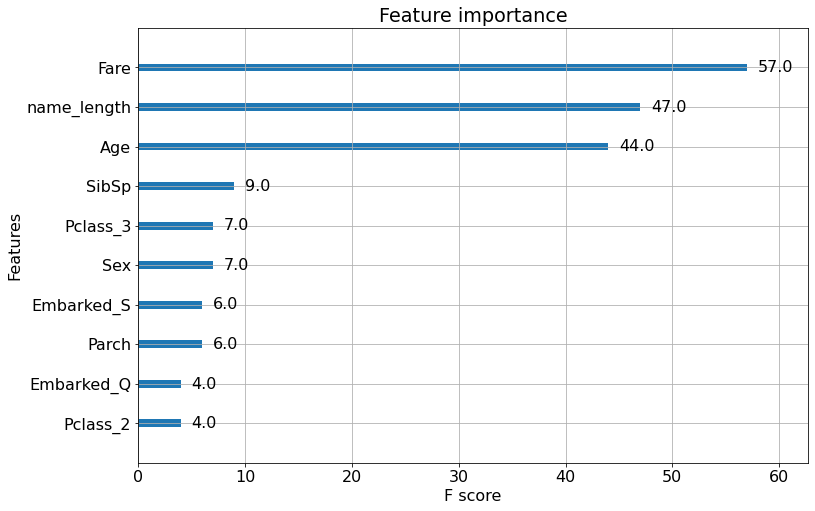

In [15]:
xgb.plot_importance(xgb_cls)

In [16]:
# niestety mam konflikty z graphvizem, ale może u was będzie działać
#xgb.plot_tree(xgb_cls)

### Przypomnijmy sobie jak działają drzewa decyzyjne
Niezależnie czy mówimy o drzewach decyzyjnych czy lasach losowych, przy tworzeniu nowych reguł decyzyjnych dla danego drzewa patrzyliśmy na Gini impurity (dla klasyfikacji) i MSE (dla klasyfikacji). W przypadku drzew wzmocnionych gradientów działa to podobnie, natomiast mamy inną metrykę oceniającą konkretną regułę tzn. `similarity score` i od razu startujemy z domyślną predykcją (dla klasyfikacji binarnej jest to prawdopodobieństwo 0.5)

\begin{equation}
\tag{similarity score for regression}
similarity  = \frac{\left( \sum^n_{i=1} (y-\hat{y}) \right)^2}{n + \lambda}
\end{equation}


\begin{equation}
\tag{similarity score for classification}
similarity  = \frac{\left(\sum^n_{i=1} (y-\hat{y}) \right)^2}{\left( \sum^n_{i=1} \hat{y}(1-\hat{y}) \right) + \lambda}
\end{equation}

gdzie $y\in\{0,1\}$ - zmianna celu, $\hat{y}\in[0,1]$ - poprzednia predykcja $y$, $\lambda\in R$ - parametr regularyzujący 

Natomiast dalej podobnie jak dla drzew dla *określonej* reguły decyzyjnej liczmy jej `gain` czyli w tym razem przyrost *similarity score* w liściach

\begin{equation}
gain = RL_{similarity} + LR_{similarity} - ROOT_{similarity}
\end{equation}

Dodatkowo pojawia się tu hiperparametr $\gamma$ określający minimalny przyrost $gain$ niezbędny do zaakceptowania nowego podziału. Jeżeli $gain-\gamma<0$ to nowo stworzony podział zostaje przycięty. Jest to element pruningu w XGBoostice, tzn. zapobiegania przeuczeniu 

W Random Forest przeglądaliśmy wszystkie unikatowo dzielące nasz zbiór reguły decyzyjne czy w XGBooscie robimy tak samo? 

Nie!

In [17]:
def similarity_reg(y_true, y_pred, _lambda = 0):
    return (np.sum(y_true- y_pred)**2)/(y_true.shape[0] + _lambda)
def similarity_clas(y_true, y_pred, _lambda = 0):
    return (np.sum(y_true- y_pred)**2)/(np.sum(y_pred*(1-y_pred)) + _lambda)

### Przykład
Załóżmy, że z zbiory titanic mamy tylko kolumnę Fare i survived

In [18]:
X = titanic["Fare"].values
y = titanic['Survived'].values

In [19]:
np.sum(y)/y.shape[0]

0.37738731856378915

In [20]:
y_init = np.full(y.shape, 0.37) # default is 0.5

In [21]:
root_similarity = similarity_clas(y, y_init)
root_similarity

0.3064580459538433

In [22]:
def calc_split_gain(vector, y, y_pred, root_gain, _lambda = 0):
    assert(vector.shape == y.shape)
    split_left = np.argwhere(vector == 0)
    split_right = np.argwhere(vector != 0)
    l_y = y[split_left]
    r_y = y[split_right]
    l_y_pred = y_pred[split_left]
    r_y_pred = y_pred[split_right]
    gain = similarity_clas(l_y, l_y_pred, _lambda) + similarity_clas(r_y, r_y_pred, _lambda) - root_gain
    return gain

In [23]:
threshold = X.mean()

In [24]:
gain = calc_split_gain((X<threshold)*1, y, y_init, root_similarity)
gain 

69.01028311446366

In [25]:
gain = calc_split_gain((X<threshold)*1, y, y_init, root_similarity+20)
gain

49.01028311446366

In [26]:
# example of gamma 
gamma = 30

In [27]:
# czy powinniśmy zatrzymać podział?
gain - gamma

19.01028311446366

Gdyby $gain - \gamma$ miało ujemną wartość (również przy gammie równej zero) ta reguła, nie stworzyłaby nowej reguły, a gałąź rodzica stałaby się liściem

## Co jest takiego eXtreme?
Tak naprawdę to chyba nic konkretnego. Natomiast XGBoost jest imponującym narzędziem dostosowanym pod obecne rozmiary problemów Machine Learningowych. Osiąga to dzięki szeregowi sprytnych rozwiązań, cześć których mam zamiar pokazać. Chyba dzięki połączeniu tylu elementów temu algorytmowi został nadany przydomek eXtreme. Mogło też oczywiście chodzić o to, że brzmiało fajnie.

### Approximate Greedy Algorithm
Domyślnie drzewa decyzyjne przeszukują wszystkie możliwe unikatowe wartości progowe dla wszystkich zmiennych by znaleźć to które jest aktualnie najlepsze. XGB nie przeszukuje wszystkich wartości progowych, a wybraną ilość (ok 33) kwantyle. Znacznie upraszcza to czas tworzenia drzew i tak naprawdę umożliwia wykorzystywanie tych struktur do większych danych.

### Weighted Quantile Sketch

Jest to dosyć skomplikowana technika, która przybliża w rozproszony sposób odpowiednie kwantyle. Co więcej XGB przy tworzeniu ich uwzglęnia odpowiednie wagi przypsane do obserwacji. Wagi te można najlepiej opisać jako niepewność modelu. Im bliższa bliższe jest prawdopodobieństwo modelu 0 lub 1 tym mnijesza waga. Dzięki temu obserwacje, które mają małą niepewność trafiają do oddzielnych ważonych kwantyli, co pomaga przy tworzeniu nowych reguł decyzyjnych lepiej je tłumaczących.

## Sparse-Aware Split Finding
Podobnie jak lasy losowe XGB jest w stanie poradzić sobie z nowymi obserwacjami z brakującymi danymi

## Cache-Aware Access
Sprytne korzystanie z pamięci by przyśpieszyć licznie similarity i output values. Ciekawe, ale mało istotne dla nas.

## Blocks for Out-of-Core Computation
Z tego co zrozumiałem dzieli nasze dane uczące na bloki na dysku twardym (jeżeli same dane są zbyt duże by trzymać je w pamięci) oraz synchronizuje ich zczywtywanie z dysku twardego, ponownie poprawiając osiągi.